In [1]:
using Random, Distributions
using Plots
# plotlyjs()
# using PlotlyJS
using DataFrames
using StatsBase
using DelimitedFiles
using LinearAlgebra
# using Distances
# using Symbolics
# using Latexify

# Problem Set 4 (Jonathan Fischer using Julia)

## 1) Reduced units

In [2]:
T = 1 #temperature
p = 0.7 #density
dt = 0.005 #time

0.005

In [3]:
function unreduce_units(val, type)
    kb = 1.380649e-23 #J/K
    sigma = 3.3e-10 #meters
    e = 300. * kb 
    m = 40. * 6.023e-23 #g
    # println(m)

    if type=="temp" #reduced temperature
        T = val
        return T*e/kb #T
    elseif type=="energy" #reduced energy
        U = val 
        return U*e #U
    elseif type=="density" #reduced density 
        sigma = sigma * 100 #convert from meters to cm 
        p = val 
        return p/(m/sigma^3)
        # println(sigma)
        # return m/sigma^3 #p
    elseif type=="time" #time 
        t = val 
        return t*(sigma*√(m/e))
    end
end

unreduce_units (generic function with 1 method)

### a) Temperature

In [4]:
T = unreduce_units(1, "temp")
println("Temperature: $(T) K")

Temperature: 300.0 K


### b) Density

In [5]:
p = unreduce_units(0.7, "density")
println("Density: $(p) g/cm³")

Density: 0.010441598870994518 g/cm³


### c) Timestep

In [6]:
t = unreduce_units(0.005,"time")
println("Time: $(t) s")

Time: 1.258398241606105e-12 s


## 2) Molecular Dynamics

### function: initialize position matrix

In [7]:
function init_position()
    readdlm("init_crds_boxl_3.5.dat")
end

init_position (generic function with 1 method)

### function: calculate distance with minimum image convention

In [8]:
function calc_dist(x1,x2, L=3.5) #calculate distance between a single pair of points along single component
    dx = x1-x2 
    dx - L*round(dx/L) #distance using minimum image convention 
end

calc_dist (generic function with 2 methods)

### function: calculate LJ potential from a pairwise distance

In [9]:
function calc_LJ(r, sigma = 1, epsilon = 0.25) # calculate Lennard_Jones potential for a pairwise distance
    4*epsilon*((sigma/r)^12 - (sigma/r)^6) 
end

calc_LJ (generic function with 3 methods)

### function: calculate LJ force scalar for pairwise distance

In [10]:
function calc_force(r, sigma = 1, epsilon = 0.25)
    48*epsilon*((sigma^12/r^13)-0.5(sigma^6/r^7))
end

calc_force (generic function with 3 methods)

### function: UPDATE ACCELERATION MATRIX A (and pairwise distances D in same loop)

In [82]:
function update_A!(A, R, mass = 1) #update distance matrix D and acceleration matrix A 
    PE = 0 #initialize potential energy
    N = length(R[:,1])
    # F = zeros((N,3))
    for i in 1:N-1
        for j in i+1:N
            dr = calc_dist.(R[i,:],R[j,:]) #calculate distance vector between two points
            r_mag = norm(dr) #calculate magnitude of distance vector
            PE += calc_LJ(r_mag) #accumulate LJ potential energy

            f_scalar = calc_force(r_mag) #scalar magnitude of force
            f_vector = f_scalar * dr / r_mag #force vector with each component
            # F[i,:] += f_vector #summing up force on i from each j 
            # F[j,:] += -f_vector

            accel_vector = f_vector/mass #get acceleration from Newtons 2nd Law
            A[i,:] = -accel_vector
            A[j,:] = +accel_vector
        end
    end
    return PE 
end

update_A! (generic function with 2 methods)

### function: calculate new position vector of a particle using velocity and acceleration 

In [84]:
function calc_position(r, v, a, dt) #update position vector for single particle
    r + (v*dt) + 0.5(a*dt^2)
end

calc_position (generic function with 1 method)

### function: UPDATE POSITION MATRIX R

In [85]:
function update_R!(R, V, A, dt) #updates position matrix R IN PLACE
    broadcast!(calc_position,R,R,V,A,dt)
end

update_R! (generic function with 1 method)

### function: calculate new velocity vector using average of old and new acceleration

In [86]:
function calc_velocity(v,a1,a2,dt) #velocity verlet update of velocity for single component
    v + 0.5*(a1+a2)*dt 
end

calc_velocity (generic function with 1 method)

### function: UPDATE VELOCITY MATRIX V 

In [87]:
function update_V!(V,A1,A2,dt)
    broadcast!(calc_velocity,V,V,A1,A2,dt)
end

update_V! (generic function with 1 method)

### function: initialize velocities

In [88]:
function init_velocity(T=1., N=3, m=1., kb=1.) #temperature, count, and mass (argon)
    V = √(1/m)*randn((N,3)) #return N x 3 matrix of initialized velocities sampled from Maxwell-Boltzmann distribution
    V[end,:] = -sum(V[1:end-1,:],dims=1) #Momentum conservation: last row equals minus sum of all other rows. Mass cancels out because same species 
    return V
end

init_velocity (generic function with 6 methods)

In [61]:
sum(initV)

1.7763568394002505e-15

### function: calculate KE 

In [89]:
function calc_KE(V, m)
    KE = 0
    for p in eachrow(V)
        v = √sum(p.^2) #get magnitude of velocity vector
        KE += 0.5(m*v^2) #accumulate KE for each particle
    end
    return KE
end

calc_KE (generic function with 1 method)

### function: calculate T

In [90]:
function calc_T(KE,kb,N)
    KE/(kb*(3N-3))*(2/3)
end

calc_T (generic function with 1 method)

### function: MD simulation

In [93]:
function MD(T, m, dt, duration)
    kb = 1. #Boltzmann constant in J/K
    # iters = Int(duration/dt)
    iters = duration 

    R = init_position() #position for t
    N = length(R[:,1]) #number of particles
    V = init_velocity(T,N,m,kb) #velocity for t
    A = zeros(N,3) 
    
    PE = Vector{Float64}(undef,iters+1) #initialize array of potential energies 
    PE[1] = update_A!(A,R,m) #initialize acceleration matrix and return initial PE
    

    KE = Vector{Float64}(undef,iters+1) #initialize array of kinetic energies 
    KE[1] = calc_KE(V,m) #initial KE 

    T_list = Vector{Float64}(undef,iters+1) #initialize array of kinetic energies 
    T_list[1] = calc_T(KE[1],kb,N) #initial temperature

    # max_A_list = []
    # push!(max_A_list,max(A))
    # max_V_list = []
    # push!(max_V_list,max(V))


    for i in 1:iters
        update_R!(R,V,A,dt) #new R updated to t+dt
        curr_A = copy(A) #A for current t
        PE[i+1] = update_A!(A, R, m) #new A updated in-place to t+dt, and returns PE into array 
        update_V!(V,curr_A,A,dt) #new V updated to t+dt
        KE[i+1] = calc_KE(V,m)
        T_list[i+1] = calc_T(KE[i+1],kb,N)
    end
    return  PE, KE, T_list, A, V, R 
end

MD (generic function with 1 method)

In [94]:
Random.seed!(1234)
PE, KE, T_list, A, V, R= MD(1.,1,0.005,50)



([-29.472115017422293, -29.653087729421262, -29.589987276681377, -29.265367216966897, -28.631298457586606, -27.58798986087231, -25.95298286088438, -23.3633873456698, -19.03793530258164, -11.007493375761527  …  6901.948711273235, 26869.98503099031, 3322.4256099749387, 366682.49903132126, 19003.287632370913, 1037.674648257075, 794.0034437758749, 18565.845043391393, 39272.691128043196, 713.6007940814543], [55.53019751018675, 55.575936014203236, 55.67034333437539, 55.83352310479817, 56.10227821824502, 56.54349026221148, 57.28390793963356, 58.58550366357275, 61.058100952711534, 66.38560752499619  …  1.362758413890044e18, 1.3627584138898191e18, 1.3627584138894728e18, 1.3627584138893184e18, 1.362758413889424e18, 1.3627584138899986e18, 1.3627584138905708e18, 1.3627584138913075e18, 1.3627584138431168e18, 1.3627584137950408e18], [0.42551875486733143, 0.42586924148814737, 0.4265926692289302, 0.4278430889256564, 0.4299025150823373, 0.43328345028514537, 0.4389571489627092, 0.44893106255611304, 0.46

In [97]:
KE

51-element Vector{Float64}:
   55.53019751018675
   55.575936014203236
   55.67034333437539
   55.83352310479817
   56.10227821824502
   56.54349026221148
   57.28390793963356
   58.58550366357275
   61.058100952711534
   66.38560752499619
   80.66052139305927
  140.8731433677053
 1329.7395074786411
    ⋮
    1.3627584138899523e18
    1.3627584138900797e18
    1.362758413890044e18
    1.3627584138898191e18
    1.3627584138894728e18
    1.3627584138893184e18
    1.362758413889424e18
    1.3627584138899986e18
    1.3627584138905708e18
    1.3627584138913075e18
    1.3627584138431168e18
    1.3627584137950408e18

In [35]:
Random.seed!(1234)
PE,KE,T = MD(1.,1,0.005,10)

30×3 Matrix{Float64}:
   2.97838     -1.99371    -0.934437
  -1.55678     -4.26355     0.519212
   6.09137     -3.29396    15.7779
  -2.0215      -5.36257    -4.26938
 -10.5133       0.140444   -3.18859
   0.388653    -1.01392     1.18462
  -1.38357      2.86553     1.24087
   1.60915     -1.89549    -3.00377
  -0.0367439   -1.34986     1.9647
   8.46652      6.29029    -9.87245
   2.61564      5.17943     2.191
  -0.241795     4.27326     3.81912
  -1.25097     -4.75134    -5.36481
   ⋮                      
  -1.78827      0.618767   -0.118167
  11.6269      -1.81224     0.474993
  -0.808594   -12.2541      2.02436
  -0.995554    -0.238097    0.122309
   0.210815     0.883238   -1.265
  -3.57729      2.6268      0.10676
   0.482501    -2.50792    -1.009
  -1.20726      1.19269    -5.82896
   3.44252      3.71325     3.9659
  11.3263       3.85355     7.21153
 -14.2663       3.22057     0.98366
 -10.5372       3.72287   -14.4546

## 3) Brownian Dynamics of a particle in a bistable potential

### energy function V(x,y)

In [234]:
function V(x,y)
    lambda = (cot((70/180)*π))^2
    5*((x^2)-1)^2 + (10*lambda*y^2)
end

V (generic function with 1 method)

### dV/dx

In [304]:
function dVx(x)
    20*x*((x^2)-1)
end

dVx (generic function with 1 method)

### dV/dy

In [303]:
function dVy(y)
    lambda = (cot((70/180)*π))^2
    20*y*lambda
end

dVy (generic function with 1 method)

### Euler update particle

In [328]:
function move_particle(x,y,kT,D,dt)
    x-(dt*(D/kT)*dVx(x))+(√(2*D*dt)*randn()), y-(dt*(D/kT)*dVy(y))+(√(2*D*dt)*randn())
end

move_particle (generic function with 1 method)

In [211]:
function move_particle_norandom(x,y,kT,D,dt)
    x-(dt*(D/kT)*dVx(x)), y-(dt*(D/kT)*dVy(y))
end

move_particle_norandom (generic function with 1 method)

In [168]:
x,y = move_particle(-1,0,10.,2.,1e-4)

(0.01159402122290526, -0.027530421620416804)

In [336]:
function BD(init_pos, D, kT, dt, iters)
    P = zeros(iters+1,length(init_pos))
    P[1,:] = init_pos
    # x,y = init_pos
    # println(iters)
    for i in 1:iters
    #     println("hi")
        P[i+1,:] .= move_particle(P[i,1],P[i,2],kT,D,dt)
        # P[i+1,:] .= x,y
        # P[i+1,2] = y
        # println((x,y))
    end
    return P 
end

BD (generic function with 1 method)

In [398]:
function make_conplot()
    trajectory_kt10 = BD([-1.0,0.],2.,10.,1e-4,100000)
    trajectory_kt5 = BD([-1.0,0.],2.,5.,1e-4,100000)
    trajectory_kt1 = BD([-1.0,0.],2.,1.,1e-4,100000)
    trajectory_kt05 = BD([-1.0,0.],2.,0.5,1e-4,100000)

    xs = collect(-1.4:0.01:1.4) #array from -5 to 5
    ys = collect(-1.9:0.01:1.9) #array from -10 to 10

    conplot = contour(xs,ys,V, title="Contour Plot",xlabel="x",ylabel="y",zlabel="Potential (V)")
    plot!(trajectory_kt10[:,1],trajectory_kt10[:,2], alpha = 0.5, label = "kT = 10" , color = :red)#, line_z=1:100000, colorbar= false)
    plot!(trajectory_kt5[:,1],trajectory_kt5[:,2], alpha = 0.5, label = "kT = 5", color = :orange)#, line_z=1:100000, colorbar= false)
    plot!(trajectory_kt1[:,1],trajectory_kt1[:,2], alpha = 0.5, label = "kT = 1", color = :green)#, line_z=1:100000, colorbar= false)
    plot!(trajectory_kt05[:,1],trajectory_kt05[:,2], alpha = 0.5, label = "kT = 0.5", color = :blue)#, line_z=1:100000, colorbar= false)
    # plot(p1,p2)
    display(conplot)
    savefig(conplot, "BD_contourplot.png")
end

make_conplot (generic function with 1 method)

In [399]:
make_conplot()

### c) Transition probability

In [392]:
function count_hit(thres, minima, traj)
    for row in eachrow(traj)
        if norm(minima-row) < thres
            return 1
        end
    end
    return 0
end

count_hit (generic function with 1 method)

In [395]:
function transition_prob(thres, minima)
    hits = 0
    for i in 1:1000
        traj = BD([-1.0,0.],2.,1.,1e-4,100000)
        # print(traj[end,:])
        hits += count_hit(thres,minima,traj)
    end
    return hits 
end

transition_prob (generic function with 1 method)

In [396]:
hits = transition_prob(0.15,[1.,0.])
println("From 1000 trajectories, $(hits) came within 0.15 of the other basin. $(hits/1000) transition probability")

From 1000 trajectories, 432 came within 0.15 of the other basin. 0.432 transition probability


In [277]:
val = 2
println(dVy(val))
println(dVy(-val))

5.2
-5.2


In [327]:
xtest_moves = []
ytest_moves = []
for i=1:100000 
    x,y = move_particle(-1,4,10.,2.,1e-4)
    push!(xtest_moves,x)
    push!(ytest_moves,y)
end

println("Average X move: $(mean(xtest_moves))")
println("Average Y move: $(mean(ytest_moves))")

Average X move: -5.672685648979661e-6
Average Y move: -0.00014822416472936602


In [287]:
x,y = move_particle_norandom(-1,val,10.,2.,1e-4)
y

1.999896

In [288]:
x,y = move_particle_norandom(-1,-val,10.,2.,1e-4)
y

-1.999896

In [323]:
dVy(4)

10.597946514543544

In [186]:
maximum(trajectory[:,2])

2.4111447884182637

In [121]:
energies = V.(trajectory[:,1],trajectory[:,2])

100001-element Vector{Float64}:
 0.0
 0.0020897251123634217
 0.01873855403253618
 0.10998734215229086
 0.07026194632888395
 0.14306322452754974
 0.28525893693402554
 0.16169090222539378
 0.15693557356444987
 0.24984286123414048
 0.09167911864166403
 0.10744695647640926
 0.04115267879221494
 ⋮
 4.990595943311654
 4.958083831927437
 4.858542307493037
 4.902272013700595
 4.716105242610898
 4.661349540746496
 4.6459853541868235
 4.672156428449011
 4.595831421114545
 4.7220240437795775
 4.578223810075614
 4.439748941806161

In [19]:
# plot(scatter(x=trajectory[:,1],y=trajectory[:,2],z=energies))
plot(scatter(x=randn(1000),y=randn(1000),z=randn(1000),
    # marker_z = randn(1000),
    marker=attr(size=4, color=[1:1000], colorscale="Viridis"),
    # colorscale="Viridis"
    line=attr(color="darkblue", width=2),
    # seriescolor = "red",
    type="scatter3d",
    mode="lines"))

data: [
  "scatter3d with fields line, marker, mode, type, x, y, and z"
]

layout: "layout with fields margin and template"

In [180]:
xs = collect(-1.4:0.01:1.4) #array from -5 to 5
ys = collect(-1.9:0.01:1.9) #array from -10 to 10

381-element Vector{Float64}:
 -1.9
 -1.89
 -1.88
 -1.87
 -1.86
 -1.85
 -1.84
 -1.83
 -1.82
 -1.81
 -1.8
 -1.79
 -1.78
  ⋮
  1.79
  1.8
  1.81
  1.82
  1.83
  1.84
  1.85
  1.86
  1.87
  1.88
  1.89
  1.9

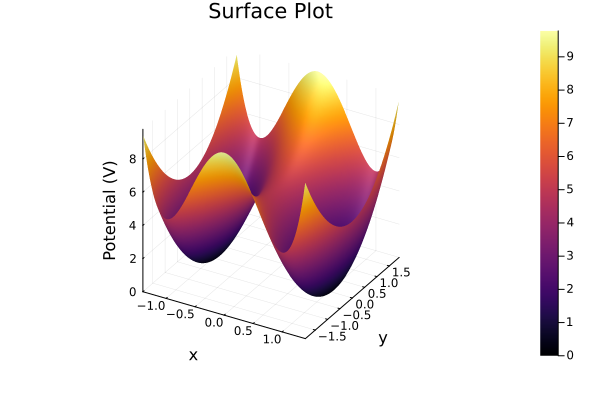

In [105]:
#surface function automatically produces evaluated meshgrid
surface(xs,ys,V, title="Surface Plot",xlabel="x",ylabel="y",zlabel="Potential (V)")
plot!(x=trajectory[:,1],y=trajectory[:,2],z=energies,linewidth = 3, color = :black)
# display(plot4)
# savefig(plot4, "BD_surfaceplot.png")

In [210]:
dVx(-1.0)

-0.0

In [233]:
dVy(0.0)

0.0

In [142]:
trajectory

100001×2 Matrix{Float64}:
 -1.0       0.0
 -0.998959  0.0282342
 -1.00845   0.0519739
 -0.987018  0.0137655
 -1.00365   0.0270159
 -1.00414   0.00206985
 -1.02043   0.00083692
 -1.02359   0.00486179
 -1.02881   0.0395807
 -1.01383   0.0456176
 -1.00864   0.041737
 -1.01803   0.0237445
 -1.02673   0.025554
  ⋮         
 -1.22668   0.96861
 -1.21116   0.975564
 -1.22689   0.968894
 -1.25222   1.01162
 -1.25672   1.00548
 -1.25042   1.01056
 -1.26341   0.970603
 -1.2598    0.947496
 -1.27846   0.952593
 -1.2617    0.936965
 -1.26787   0.947668
 -1.24118   0.969544

In [123]:
@show Plots.supported_styles();

Plots.supported_styles() = [:auto, :dash, :dashdot, :dashdotdot, :dot, :solid]


In [124]:
@show Plots.supported_markers()

Plots.supported_markers() = [:+, :auto, :circle, :cross, :diamond, :dtriangle, :heptagon, :hexagon, :hline, :ltriangle, :none, :octagon, :pentagon, :pixel, :rect, :rtriangle, :star4, :star5, :star6, :star7, :star8, :utriangle, :vline, :x, :xcross]


25-element Vector{Symbol}:
 :+
 :auto
 :circle
 :cross
 :diamond
 :dtriangle
 :heptagon
 :hexagon
 :hline
 :ltriangle
 :none
 :octagon
 :pentagon
 :pixel
 :rect
 :rtriangle
 :star4
 :star5
 :star6
 :star7
 :star8
 :utriangle
 :vline
 :x
 :xcross

In [173]:
D = 2.
dt = 1e-4
randn(100)*√(2*D*dt) 

100-element Vector{Float64}:
  0.019895303695646058
  0.044022458133632425
 -0.013321466034049672
 -0.0012918824361141128
 -0.006166463862245867
  0.000379481954070326
 -0.029838749793107515
 -0.016993418905981807
 -0.022068437034210586
 -0.0034031591031186293
 -0.012809358501288106
 -0.02019665218855411
 -0.004228013639942763
  ⋮
 -0.03157297074368769
  0.018787057184592025
  0.004137561728267032
 -0.009918723756674071
  0.006039075708745618
  0.010711659264850975
  0.009636686510183904
  0.037475694525024444
 -0.01748128698718296
  0.0015374675500674782
  0.006577594110314975
 -0.01118545414925625

In [174]:
gaussian = Normal(0,√(2*D*dt))
sample = rand(gaussian,100)

100-element Vector{Float64}:
 -0.011620514534941213
 -0.018068896115254474
 -0.008545557037068606
  0.0011378909395327432
  0.004800580203685984
 -0.032752773876527676
 -0.01977685301180601
  0.02225126883005574
  0.028597452291600604
  0.011553786208351595
 -0.05964635895229474
  0.014707299468880117
  0.017294829685584982
  ⋮
  0.010886393756799924
  0.02040227460000932
  0.03056109362450926
 -0.009960911902678478
 -0.022540945515436058
  0.005198141688117686
  0.01613370535293393
 -0.01950139048798046
  0.026826186994754645
  0.030356989036903103
  0.02170730057256701
 -0.019772046165314045